# PRÁCTICA GUIADA : Curva ROC y Area bajo la curva

## 1. Introducción

Seguimos trabajando sobre el dataset de RRHH. La variable dependiente es la misma ($P(left=1|X)$)

In [1]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../Data/HR_comma_sep.csv')
df.sample(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
8509,0.60,0.98,4,192,3,0,0,0,technical,low
11100,0.96,0.85,4,247,3,0,0,0,sales,high
6038,0.53,0.62,3,185,3,0,0,0,marketing,medium
13886,0.17,0.61,6,154,10,1,0,0,sales,medium
8234,0.94,0.80,5,245,3,1,0,0,product_mng,medium
10639,0.75,0.83,4,133,4,0,0,0,hr,high
3721,0.91,0.65,5,174,2,0,0,0,technical,medium
42,0.40,0.46,2,127,3,0,1,0,technical,low
9210,0.91,0.88,5,223,3,0,0,0,support,low
14970,0.78,0.93,4,225,5,0,1,0,sales,medium


In [3]:
train_cols = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 
              'time_spend_company', 'Work_accident', 'promotion_last_5years']
X = df[train_cols]
y = df['left']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Utilizamos sklearn para estandarizar la matriz de Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

* Definimos y entrenamos el modelo (Regresión Logística)

In [6]:
clf = LogisticRegression(C=1e10)
clf.fit(X_train, y_train)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## 2. Ajustando los umbrales

Hasta ahora siempre hemos trabajado asumiendo que si $p(y=1) > 0.5$, entonces, la predicción del modelo será que $y=1$. Ahora bien, ¿qué sucede si queremos maximizar o modificar la performance del modelo en alguna de las métricas que hemos visto antes (sentivity, recall, etc.)? ¿Cómo podemos lograr esto?

Una forma es haciendo variar esa regla que habíamos definido más arriba: ajustar los umbrales.

Veamos cómo funciona. En primer lugar, obtengamos las predicciones de probabilidad ($p(y=1)$) y no las predicciones de la clase de $y$.

In [7]:
X_test = scaler.transform(X_test)

In [8]:
clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

In [9]:
clf.predict_proba(X_test)

array([[0.96331336, 0.03668664],
       [0.93112383, 0.06887617],
       [0.8126686 , 0.1873314 ],
       ...,
       [0.93393643, 0.06606357],
       [0.7897889 , 0.2102111 ],
       [0.28266285, 0.71733715]])

Notar que el método `predict_proba` nos devuelve una array en el cual aparecen dos probabilidades de cada instancia del test set: $p(y=0)$ y $p(y=1)$, en ese orden.

`sklearn` realiza la predicción de la clase de $y$ eligiendo para cada clase la mayor probabilidad de este array.

In [10]:
print(np.mean(clf.predict_proba(X_test)[:,1] > 0.5))
print(np.mean(clf.predict(X_test)))

y_pred_orig = clf.predict(X_test)

0.11878787878787879
0.11878787878787879


Guardemos las probabilidades de ambas clases en un array y $p(y=1)$ en otro:

In [11]:
y_probs_logit = clf.predict_proba(X_test)
y_probs_logit_left = y_probs_logit[:,1]

In [12]:
y_probs_logit_left

array([0.03668664, 0.06887617, 0.1873314 , ..., 0.06606357, 0.2102111 ,
       0.71733715])

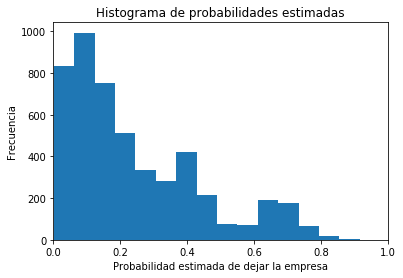

In [13]:
# 15 bins
plt.hist(y_probs_logit_left, bins=15)

# x-axis de 0 a 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas')
plt.xlabel('Probabilidad estimada de dejar la empresa')
plt.ylabel('Frecuencia')
plt.show()

* La gran mayoría de las probabilidades predichas van de 0.0 a 0.4
* Hay un escaso número de probabilidades estimadas mayores a 0.5
* La mayor parte de los casos van a ser predichos como $y=0$ es decir, que no se van de la empresa.

Una posible solución es, entonces, variar el umbral -$y = 1$ si $p(y=1) > 0.5$-. 

En este caso, lo lógico sería bajar el umbral. Por lo tanto se incrementará la sensitivity. ¿Por qué?

* Aumentaremos la cantidad de TP
* El clasificador será más "sensible" a las instancias positivas

In [30]:
from sklearn.preprocessing import binarize
y_pred_logit = binarize(y_probs_logit, 0.3)[:,1]

# Otra forma
#y_pred_logit = (y_probs_logit_left > 0.3)

* Veamos la matriz de confusión con las predicciones basadas en el modelo original

In [32]:
confusion_matrix(y_test,y_pred_orig)

array([[3464,  305],
       [ 898,  283]])

* Veamos la matriz de confusión con las predicciones basadas en el modelo modificado

In [33]:
confusion_matrix(y_test,y_pred_logit)

array([[3046,  723],
       [ 358,  823]])

* ¿Qué pasó con la sensitividad (o recall)? 

$\large recall = \frac{TP}{(FN + TP)}$

In [17]:
print('Recall umbral 0.5=', recall_score(y_test, y_pred_orig))
print('Recall umbral 0.3=', recall_score(y_test, y_pred_logit))

Recall umbral 0.5= 0.23962743437764605
Recall umbral 0.3= 0.6968670618120237


* ¿Qué pasó con la specificity? 

$\large specificity = \frac{TN}{(TN + FP)}$

In [18]:
def specificy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return(specificity)

In [19]:
print('Spec umbral 0.5 =', specificy(y_test, y_pred_orig))
print('Spec umbral 0.3 =', specificy(y_test, y_pred_logit))

Spec umbral 0.5 = 0.9190766781639692
Spec umbral 0.3 = 0.8081719288936058


In [20]:
print('Acc umbral 0.5 =', accuracy_score(y_test, y_pred_orig))
print('Acc umbral 0.3 =', accuracy_score(y_test, y_pred_logit))

Acc umbral 0.5 = 0.756969696969697
Acc umbral 0.3 = 0.7816161616161617


* Se puede ajustar el umbral para las predicciones en clasificadores binarios
* El ajuste de este umbral repercute sobre las diferentes medidas de performance.
* Particularmente, sensitivity y specificity tiene una relación inversa
    * siempre al mejorar uno, empeorará el otro

## 3. Curvas ROC y área bajo la curva (AUC)

Muy útil si queremos visualizar cómo se mueven sensitivity y specificity ante diversos umbrales. 

La curva ROC se basa en $TPR$ (tasa de verdaderos positivos) y $FPR$ (tasa de falsos negativos).

* Definamos las metricas de True Positive Ratio y False Positive Rate y se las asignamos las los valores predichos vs los valores de test (observados vs esperados).
* El método `roc_curve` toma como parámetros dos valores: los valores observados del target y un array de probabilidades (NO recibe las predicciones de la clase).
* Devuelve tres elementos en forma de arrays: la tasa de falsos positivos ($FPR$), la tasa de verdaderos positivos ($TPR$) y los umbrales

In [34]:
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_probs_logit[:,1])

* Convertimos los valores en un objeto dataframe y graficamos la curva ROC

In [35]:
df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

In [23]:
df

,fpr,tpr,thr
0,0.000000,0.000000,1.915232
1,0.000531,0.000000,0.915232
2,0.001061,0.000000,0.856503
3,0.001061,0.000847,0.844004
4,0.002123,0.000847,0.825721
5,0.002653,0.000847,0.820730
6,0.003715,0.000847,0.806540
7,0.003715,0.001693,0.805941
8,0.004245,0.001693,0.800933
9,0.004776,0.001693,0.799475


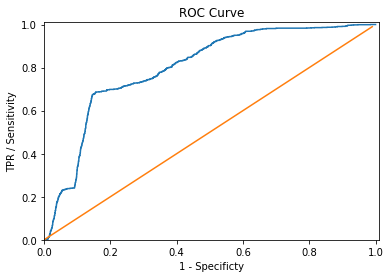

In [24]:
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show() 

* Calculamos el área bajo la curva ROC

In [36]:
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.7999370505273985


## 4. Comparando modelos

Evaluamos las medidas vistas en ambas prácticas para un clasificador Naïve Bayes.

In [37]:
from sklearn.naive_bayes import GaussianNB

nbc = GaussianNB()

In [38]:
nbc.fit(X_train, y_train)
y_preds_nb = nbc.predict(X_test)
y_probs_nb = nbc.predict_proba(X_test)

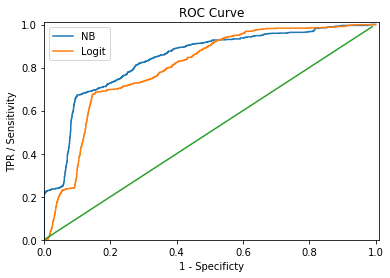

In [39]:
fpr_nb,tpr_nb,thr_nb = roc_curve(y_test, y_probs_nb[:,1])
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_probs_logit[:,1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['NB','Logit'])
plt.show() 

In [40]:
print('AUC-NB=', auc(fpr_nb, tpr_nb))
print('AUC-Logit=', auc(fpr_log, tpr_log))

AUC-NB= 0.8399519768762908
AUC-Logit= 0.7999370505273985
